# Modeling Crop Yield: Landsat + Sentinel
## Python modules

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Satellite Parameters

 - For a description of the Landsat 8 mission, see the US Geological metadata [here.]()
 - For a description of the Sentinel 2 mission, see the US Geological metadata [here.]()

We'll use **ls8** and **sn2** for Landsat 8 and Sentinel 2 missions, respectively, throughout this notebook to denote satellite specific parameters. 

In [2]:
ls8_satellite = "landsat-8-c2-l2"
sn2_satellite = "sentinel-2-l2a"

### Choose band combination.

 - For a description of **Landsat 8** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)
 - For a description of **Sentinel 2** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2#:~:text=4%20bands%20at%2010%20meter,%2Dinfrared%20(842%20nm)

According to our results, bands **(insert band selection here)** result in the best model performance for Landsat, and **(insert band selection here)** result in the best model performance for Sentinel for the task of predicting maize yields in Zambia.

In [3]:
# Landsat bands
ls8_bands = "1-2-3-4-5-6-7"

# Sentinel bands
# sn2_bands = "2-3-4"
sn2_bands = "2-3-4-8"
# sn2_bands = "2-3-4-5-6-7-8-11-12"

### Choose the number of points that were featurized.

Each value in the following chunk represents the amount of thousands of points that were featurized in each respective feature file. These points represent a uniform subset of the spatial grid of Zambia. Points are spaced at uniform intervals for each selection, measured in kilometers in the longitudinal direction for each set of features. Selecting a greater quantity of points results in a denser spatial sample and increases the spatial resolution of the model. Regardless of the quantity of points selected, each point is buffered by the same distance, resulting in a 1km^2 cell around each point.

Selection remains the same for Landsat and Sentinel.

In [4]:
points = 15
# points = 20

### Choose which months to use in the model.

Note that months 10, 11, and 12 get pushed to the next year because the growing season (November - May) spans the calendar year. Maize is planted in November, starts to change color with maturity in May, and is harvested in June - August. According to our results, subsetting the months to **(insert month selection here)** increases model performance.

Selection remains the same for Sentinel and Landsat

In [5]:
month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

#### Choose to keep only areas with crops (`True`) or to keep all points (`False`)

Selecting `True` applies a "cropland mask" to the spatial grid of Zambia. This retains only the regions of the country in which maize is  grown, according to the **(insert source here)**. As a result, the spatial extent of the features that are fed into the model are highly subset for the specific task at hand: modeling maize yields. According to our results, selecting `True` **(insert increases or decreases here)** model performance.

Selecting `False` results in modeling with the maximum spatial extent of the features, with more generalized features as a result.

In [6]:
# crop_mask = True
crop_mask = False

Choose a weighted average (`True`) or a simple mean (`False`) to use when collapsing features to administrative boundary level.

In [7]:
# weighted_avg = True
weighted_avg = False

#### Impute NA values by descending group levels (True) or `scikit learn`'s simple imputer (False)

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [8]:
impute_manual = True
# impute_manual = False

### Unchanging parmaters

The parameters in the following chunk are set for the country of Zambia for with 1000 features, regardless of the satellite selected. The start years for each satellite reflect the respective years that Landsat 8 and Sentinel 2A missions began.

The number of features is set to 1000 to serve as a staple parameter among the several other parameters varied during the model optimization process. Changing this parameter in the following code chunk will result in an error because featurizing landsat imagery for a different number of features was outside the scope of this project.

In [9]:
# set home directory
taylor_data_dir = "/capstone/cropmosaiks/data"  

# set plot sizes
if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

In [10]:
country_code = "ZMB"
num_features = 1000

year_start = 2015 
year_end = 2018     

# set file paths
ls8_feature_file_name = (f'{ls8_satellite}_bands-{ls8_bands}_{country_code}_{points}k-points_{num_features}-features')
sn2_feature_file_name = (f'{sn2_satellite}_bands-{sn2_bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights_{points}k-points')

## Administrative boundaries 

Administrative boundaries reflect the **(insert number of districts in dataset)** district boundaries within the country of Zambia. A district can be likened to a state within the larger U.S.A. We subset the spatial grid to district level becuase the crop yield data is at the district level of specificity. The features are originally produced at higher spatial resolution, then summarized to the district level in order to train the model with ground-truth crop data. 

<AxesSubplot:>

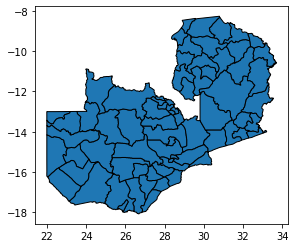

In [11]:
country_shp = geopandas.read_file(f'{taylor_data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
country_shp.plot(linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Crop yield

Zambian maize yield data reflects the predicted annual maize yield provided by farmers in the month of May, when the maize matures and changes colors prior to harvest, which allows the farmers to estimate what their yield will be in the following months. These predictions are in units of metric tons per hectare and provide valuable insight to the Zambian government as they plan for the quanitites of food to import into the country in the future. For more metadata, see the websites for the [Central Statistics Office of Zambia (CSO)](https://www.zamstats.gov.zm/) and the [Summary statistics from CSO.](https://www.zamstats.gov.zm/agriculture-environment-statistics/)

In order to standardize the names of all districts shared between the geoboundaries and the crop yield data, we correct for spelling, dashes, and apostrophes. 


In [12]:
crop_df = pd.read_csv(taylor_data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [13]:
list(set(crop_districts) - set(country_districts))

['Ikelenge', 'Mafinga']

In [14]:
list(set(country_districts) - set(crop_districts))

[]

In [15]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Crop land

In [16]:
weights = pd.read_feather(f"{taylor_data_dir}/weights/{weight_file_name}.feather")
# weights

<AxesSubplot:>

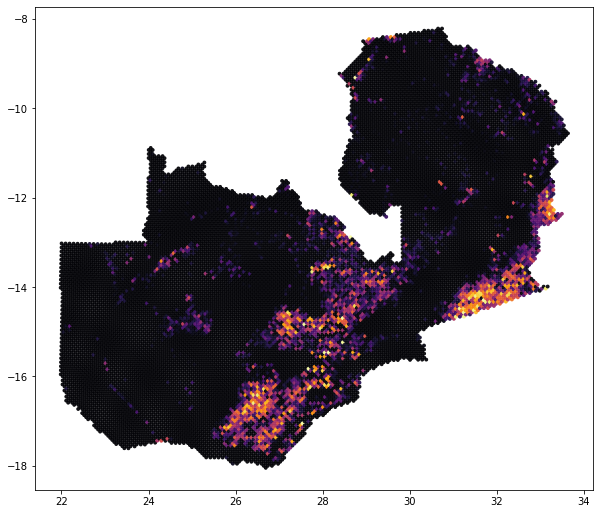

In [17]:
weights_gdf = geopandas.GeoDataFrame(
    weights, 
    geometry = geopandas.points_from_xy(x = weights.lon, y = weights.lat), 
    crs='EPSG:4326'
)
weights_gdf.plot(figsize = (10,10),
                 cmap = 'inferno',
                 markersize = marker_sz,
                 alpha = .9,
                 column = 'crop_perc')
# plt.axis('off')

In [18]:
weights.crop_perc = weights.crop_perc.fillna(0)
# #weights.crop_perc = weights.crop_perc + 0.0001

## Features

Append annual features files together into one file: `features_raw`.

#### Landsat 8

In [19]:
features_ls8_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {ls8_feature_file_name}_{yr}.feather")
    features_ls8 = pd.read_feather(f"{taylor_data_dir}/features/{ls8_satellite}/{ls8_feature_file_name}_{yr}.feather")
    
    if (yr == year_start):
        features_ls8 = features_ls8[features_ls8.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_ls8_raw = pd.concat([features_ls8_raw, features_ls8], axis=0)
    
    print("feature.shape", features_ls8_raw.shape)
    print("Appending:", yr)
    print("")

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2015.feather
feature.shape (24712, 1004)
Appending: 2015

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2016.feather
feature.shape (144907, 1004)
Appending: 2016

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2017.feather
feature.shape (244560, 1004)
Appending: 2017

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2018.feather
feature.shape (358738, 1004)
Appending: 2018



#### Sentinel 2

In [20]:
features_sn2_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {sn2_feature_file_name}_{yr}.feather")
    features_sn2 = pd.read_feather(f"{taylor_data_dir}/features/{sn2_satellite}/{sn2_feature_file_name}_{yr}.feather")
    
    if (yr == year_start):
        features_sn2 = features_sn2[features_sn2.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_sn2_raw = pd.concat([features_sn2_raw, features_sn2], axis=0)
    
    print("feature.shape", features_sn2_raw.shape)
    print("Appending:", yr)
    print("")

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2015.feather
feature.shape (9641, 1004)
Appending: 2015

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2016.feather
feature.shape (145645, 1004)
Appending: 2016

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2017.feather
feature.shape (262443, 1004)
Appending: 2017

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2018.feather
feature.shape (411433, 1004)
Appending: 2018



In [21]:
# Create copies of both feature datasets
features_ls8 = features_ls8_raw.copy()
features_sn2 = features_sn2_raw.copy()

We want to carry the months October, November, and December over to the following year's date. These months represent the start of the growing season for the following year's maize yield

In [22]:
# Landsat
features_ls8['year'] = np.where(
    features_ls8['month'].isin([10, 11, 12]),
    features_ls8['year'] + 1, 
    features_ls8['year'])

features_ls8 = features_ls8[features_ls8['year'] <= year_end]
features_ls8.sort_values(['year', 'month'], inplace=True)


# Sentinel
features_sn2['year'] = np.where(
    features_sn2['month'].isin([10, 11, 12]),
    features_sn2['year'] + 1, 
    features_sn2['year'])

features_sn2 = features_sn2[features_sn2['year'] <= year_end]
features_sn2.sort_values(['year', 'month'], inplace=True)

### Filter month range

In [23]:
# subset the features to only the month range selected at the top of the notebook
features_ls8 = features_ls8[features_ls8.month.isin(month_range)]
features_sn2 = features_sn2[features_sn2.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon', 'lat', 'year', 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. This results in a Tidy data structure, with each row representing an image, and each column representing a feature for a certain month.

In [24]:
# Landsat
features_ls8 = features_ls8.set_index(['lon','lat', "year", 'month']).unstack()
features_ls8.columns = features_ls8.columns.map(lambda x: '{}_{}_ls8'.format(*x))

# Sentinel
features_sn2 = features_sn2.set_index(['lon','lat', "year", 'month']).unstack()
features_sn2.columns = features_sn2.columns.map(lambda x: '{}_{}_sn2'.format(*x))

In [25]:
features_sn2.head(5)

0_1_sn2  0_2_sn2  0_3_sn2  0_4_sn2  0_5_sn2  \
lon       lat        year                                                
21.981760 -14.016935 2016      NaN      0.0      NaN      NaN      NaN   
                     2017      NaN      NaN      0.0      NaN      0.0   
                     2018      0.0      NaN      NaN      0.0      0.0   
21.982866 -15.954329 2016      NaN      0.0      NaN      NaN      NaN   
                     2017      NaN      NaN      NaN      0.0      0.0   

                           0_6_sn2  0_7_sn2  0_8_sn2  0_9_sn2  0_10_sn2  ...  \
lon       lat        year                                                ...   
21.981760 -14.016935 2016      0.0      0.0      0.0      0.0       0.0  ...   
                     2017      0.0      0.0      0.0      0.0       0.0  ...   
                     2018      0.0      0.0      0.0      0.0       0.0  ...   
21.982866 -15.954329 2016      0.0      NaN      0.0      0.0       0.0  ...   
                     2017      0.0      0.0      0.0      0.0       0.0  ...   

                           999_3_sn2  999_4_sn2  999_5_sn2  999_6_sn2  \
lon       lat        year                                               
21.981760 -14.016935 2016        NaN        NaN        NaN   3.532144   
                     2017   4.734617        NaN   3.432352   3.232895   
                     2018        NaN   3.210268   3.334542   3.225121   
21.982866 -15.954329 2016        NaN        NaN        NaN   5.227335   
                     2017        NaN   3.161662   3.721432   3.467443   

                           999_7_sn2  999_8_sn2  999_9_sn2  999_10_sn2  \
lon       lat        year                                                
21.981760 -14.016935 2016   3.849683   4.034249   4.161150    3.833862   
                     2017   3.582984   3.557588   3.906777    3.954087   
                     2018   3.383499   3.428070   3.969848    4.198930   
21.982866 -15.954329 2016        NaN   5.875107   5.971619    6.791008   
                     2017   3.776038   4.729180   4.564546    6.165408   

                           999_11_sn2  999_12_sn2  
lon       lat        year                          
21.981760 -14.016935 2016         NaN    3.656577  
                     2017         NaN    3.663198  
                     2018         NaN         NaN  
21.982866 -15.954329 2016    7.082443    6.455033  
                     2017    5.689834         NaN  

[5 rows x 12000 columns]

### Join Landsat & Sentinel dataframes

In [26]:
features = features_ls8.join(features_sn2, how = 'left')

### Replace "inf" values with `NaN`

Infinity values are the result of **(insert reason here)**. We replace them with `NaN` because **(insert reason here)**.

In [27]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
# features

### Attach crop weights
Attach weight to each point (% area cropped of surrounding 1 km^2).

In [28]:
features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features = features.drop(["geometry"], axis = 1)
# features

### Mask croppped regions
Any 1 km^2 cell with a crop percentage > 0 will be retained.\
The mask will not be applied if `crop_mask` is set to `False` at the top of this notebook

In [29]:
if crop_mask:
    features = features[features.crop_perc > 0]
else:
    pass
# features

### Make "features" a `GeoDataFrame`

The coordinate reference system is set to **EPSG 4326 - WGS 84**, the latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System.

In [30]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Plot any single features

In [31]:
# mn = 7
# yr = 2017
# sat = 'sn2' # ls8
# feature = 854

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}_{sat}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

### Drop 'lat' and 'lon' columns

In [32]:
# Drop the redundant independent lon and lat columns now that they are in a geometry column
features = features.drop(['lon', 'lat'], axis = 1)

### Join features to country geometry

In [33]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')
# features

### Correct column names and drop geometry

In [34]:
features = (
    features
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
points = features.copy()
points = features[['geometry']]
features = features.drop(['geometry'], axis = 1)
# features

### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. This manual imputation of values gives the user more control and transparency over how the imputation is executed. Imputation occurs in three steps.

 1. The NA values are imputed by  `month`, `year`, and `district` which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. 
 2. The remaining NA values that could not be imputed by step 1 are imputed by only `district` across every `year`.
 3. Lastly, the remaining NA values are crudely dropped. 

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [35]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features) * len(month_range) * num_features
num_cells

541056000

In [36]:
class bcolors:
    BL = '\x1b[1;34m' #GREEN
    GR = '\x1b[1;36m' #GREEN
    YL = '\x1b[1;33m' #YELLOW
    RD = '\x1b[1;31m' #RED
    RESET = '\033[0m' #RESET COLOR

In [37]:
%%time
if impute_manual:
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Starting total row count: {bcolors.BL}{ln_ft}{bcolors.RESET}',
          f'\nPre-Impute NaN row count: {bcolors.RD}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPre-Impute NaN row %: {bcolors.RD}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPre-Impute NaN cell %: {bcolors.RD}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 1: Filling NaN values by month, year, and district group average')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 1 NaN row count: {bcolors.YL}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 1 NaN row %: {bcolors.YL}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 1 NaN cell %: {bcolors.YL}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 2: Filling NaN values by month and district group average')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 2 NaN row count: {bcolors.GR}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 2 NaN row %: {bcolors.GR}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 2 NaN cell %: {bcolors.GR}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 3: Drop remaining NaN values')
    features = features.dropna(axis=0)
    print(f'Ending total row count: {bcolors.BL}{len(features)}{bcolors.RESET}\n')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

Starting total row count: 45088 
Pre-Impute NaN row count: 45088 
Pre-Impute NaN row %: 100.00 
Pre-Impute NaN cell %: 75.89 

Step 1: Filling NaN values by month, year, and district group average
Post step 1 NaN row count: 45088 
Post step 1 NaN row %: 100.00 
Post step 1 NaN cell %: 40.70 

Step 2: Filling NaN values by month and district group average
Post step 2 NaN row count: 23128 
Post step 2 NaN row %: 51.30 
Post step 2 NaN cell %: 6.61 

Step 3: Drop remaining NaN values
Ending total row count: 21960

CPU times: user 10min 15s, sys: 56.9 s, total: 11min 12s
Wall time: 11min 11s


### Save copy of completed data 

In [38]:
features_copy = features.copy()
features_copy['geometry'] = points.geometry

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [39]:
var_cols = features.columns[1:-2].values.tolist()
features.columns[1:-2]

Index(['0_1_ls8', '0_2_ls8', '0_3_ls8', '0_4_ls8', '0_5_ls8', '0_6_ls8',
       '0_7_ls8', '0_8_ls8', '0_9_ls8', '0_10_ls8',
       ...
       '999_3_sn2', '999_4_sn2', '999_5_sn2', '999_6_sn2', '999_7_sn2',
       '999_8_sn2', '999_9_sn2', '999_10_sn2', '999_11_sn2', '999_12_sn2'],
      dtype='object', length=24000)

In [40]:
%%time
if weighted_avg:
    features_summary = (
        features
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
else:
    features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

CPU times: user 2.12 s, sys: 1.25 s, total: 3.37 s
Wall time: 3.37 s


### Join crop data

In [41]:
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
crop_df_x.head()

,district,year,yield_mt
0,Chadiza,2016,1.876427
1,Chadiza,2017,2.882947
2,Chadiza,2018,1.299279
3,Chama,2016,1.257456
4,Chama,2017,2.308008


In [42]:
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_df_x.set_index(["district", "year"]))
    .reset_index())
#features_summary

## Model

In [43]:
model_year = features_summary[features_summary.year.isin([
   2016,
   2017,
   2018,
])]

### Define `x's` and `y's`

In [44]:
x_all = model_year.drop([
    'district', 
    'year', 
    'yield_mt',
     "crop_perc"
], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(model_year.yield_mt.to_numpy() + 1)

In [45]:
len(x_all)

69

In [46]:
len(y_all)

69

### Standardize Features
We will use the default configuration and scale values to subtract the mean to center them on 0.0 and divide by the standard deviation to give the standard deviation of 1.0. First, a StandardScaler instance is defined with default hyperparameters.

In [47]:
scalar = StandardScaler().fit_transform(x_all)
x_all = pd.DataFrame(scalar)
#x_all[3].hist()

<AxesSubplot:>

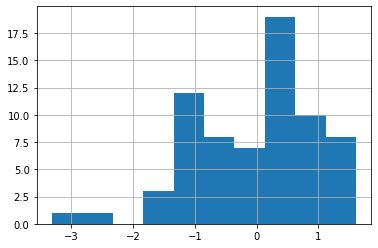

In [48]:
x_all[3].hist()

### Split into train and test sets

In [49]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [50]:
print("Total N: ", len(x_all), "\n", 
      "Train N: ", len(x_train), "\n",
      "Test  N: ", len(x_test), sep = "")

Total N: 69
Train N: 55
Test  N: 14


### Train model
Now that our data has been standardized, we can use the same penalazation fac

In [51]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

### Validation set $R^2$ performance

In [52]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.70


## Train Set

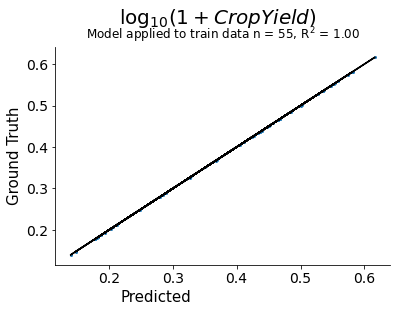

In [53]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(np.squeeze(y_pred), np.squeeze(y_train), 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [54]:
print(f"Training R^2 = {r2_score(y_train, y_pred):0.2f}\nPearsons R = {pearsonr(y_pred, y_train)[0]:0.2f}")

Training R^2 = 1.00
Pearsons R = 1.00


### Test set

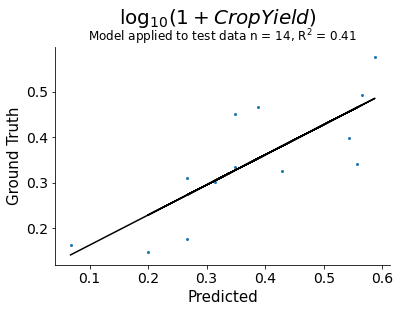

In [55]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(np.squeeze(y_pred), np.squeeze(y_test), 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [56]:
print(f"Testing set R^2 = {r2_score(y_test, y_pred):0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Testing set R^2 = 0.41
Testing set pearsons R = 0.80


### Plot the fitted features

In [57]:
pred_features = features_copy.copy()

In [58]:
x_all = pred_features.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [59]:
pred_features = geopandas.GeoDataFrame(pred_features)

In [60]:
pred_features['fit'].mask(pred_features['crop_perc']==0, 0, inplace=True)
# pred_features.loc[pred_features["crop_perc"] == 0, "fit"] = 0   ### Does same thing but differently

In [61]:
# pred_features = pred_features[pred_features.crop_perc > 0].reset_index(drop = True)

In [62]:
pred_features['fit'].mask(pred_features['fit'] > 2, 0, inplace=True)

In [63]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

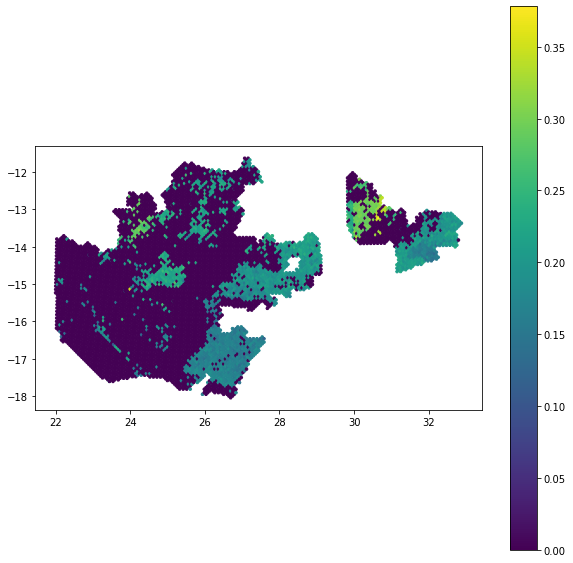

In [64]:
plot_features.plot(figsize = (10,10),
                   marker='H',
                   legend = True,
                   markersize = marker_sz,
#                    alpha = .9,
                   column = 'fit')

## Yield and Residual Plots
### Create data frame 

In [65]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt',
    'crop_perc'
], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
#demean by location
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)
# residual_gdf

### Crop yield histogram

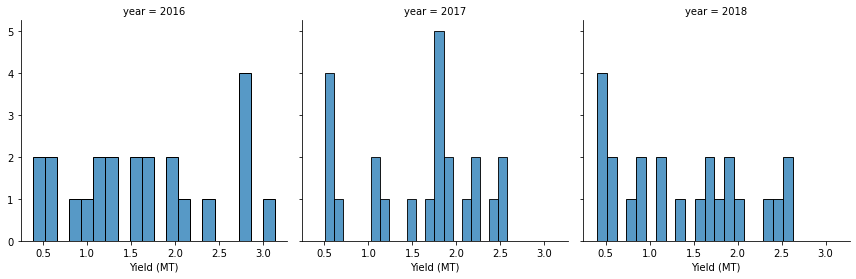

In [66]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

### Save copy of completed data 

In [67]:
features_copy = features.copy()
features_copy['geometry'] = points.geometry

## Save output

In [68]:
features.to_feather(f'{ls8_satellite}_{sn2_satellite}_"combined".feather')

/opt/python/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.
